# Contents
- [Imports](#imports)
- [Data Collection](#collection)
- [Video Creation](#video)
- [Video Processing](#processing)
- [Keypoint Creation](#keypoint)
    - [Method Investigation](#investigation)
    - [Keypoint Extraction](#extraction)

---
# Imports<a id=imports></a>

In [16]:
import argparse
import logging
import time
import os
from IPython.display import HTML
from IPython.display import Image

import cv2
import numpy as np

import re
import pandas as pd

from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

---
# Data Collection <a id=collection></a>
In this project, I will be creating the data required for the modelling process. The process to creating the data will take place in 3 steps:
1. Creating videos of boxing moves
2. Clipping these videos to only have relevant segments, and
3. Converting these processed videos into keypoint data.

---
# Video Creation<a id=video></a>
There are [4 basic moves in boxing](https://en.wikipedia.org/wiki/Boxing#Punches), exclusive of the neutral 'guard' position. The four moves are listed:
1. jab 
2. cross/straight (henceforth referred to as the cross)
3. hook
4. uppercut

Inclusive of the guard position and a control group, we have a multiclass classification problem of 6 classes.<br/>

To make our model robust enough to detect the moves from various positions, distances and angles, we develop a systematic way of creating our video for each of our classes.<br/>
For each of our moves, we vary the angles, distances and movements in the following ways:
1. There will be five angles:
    - subject angled 90$^\circ$ facing the right with respect to the camera,
    - subject angled 45$^\circ$ facing the right with respect to the camera,
    - subject facing the camera head-on,
    - subject angled 45$^\circ$ facing the left with respect to the camera, and
    - subject angled 90$^\circ$ facing the left with respect to the camera.<br><br>
2. There will be two distances (only two due to space constraints):
    - subject as far from the camera as possible, and
    - subject as close to the camera as possible, with torso and arms within the bounds of the camera's field-of-view<br><br>
3. There will be the following movement variations if the space allows for it:
    - subject performs the move while stationary
    - subject executes the move while taking a step to the left
    - subject executes the move while taking a step to the right
    - subject executes the move while taking a step forward
    - subject executes the move while taking a step backward
    
In this manner,performing 5 of the same moves for the same variation, we have 5 moves $\times$ 5 angles $\times$ 2 distances $\times$ 5 movements for 250 moves performed per video for each move.<br/>
We take 5 videos of our moves inclusive of our neutral guard position and we take an approximately 1 minute long control video where we perform random movements wholly unrelated to boxing.

An example of the video we took for the *hook* move is shown below.

In [13]:
def showvideo(i):
    display(HTML("""<video width="1500" height="1000" controls><source src="{}" type="video/mp4"></video>""".format(i)))
    
showvideo('../train/hook/WIN_20190724_02_55_03_Pro.mp4')    

---
# Video Processing<a id=processing></a>
To process our videos, we need to cut out unnecessary footage from our created videos that will not give us our desired keypoint data.<br/>
To do that, we make use of the freeware [OpenShot](https://www.openshot.org/) to trim our videos.<br/>
For the videos of our 4 basic moves, we make it a point to remove the video frames where the subject's position is similar to that of a guard such that our keypoint data won't overlap.<br/><br/>
An example of the processed *hook* move video is shown below.

In [14]:
showvideo('../train/Hookclean.mp4')

---
# Keypoint Creation<a id=keypoint></a>

## Method Investigation<a id=investigation></a>
In the Jupyter notebook imgtest.ipynb, we perform a keypoint investigation to investigate how we might extract our keypoint data for our modelling purposes.<br/>
We use and modify the code from run.py to execute the estimation on the image shown below. 

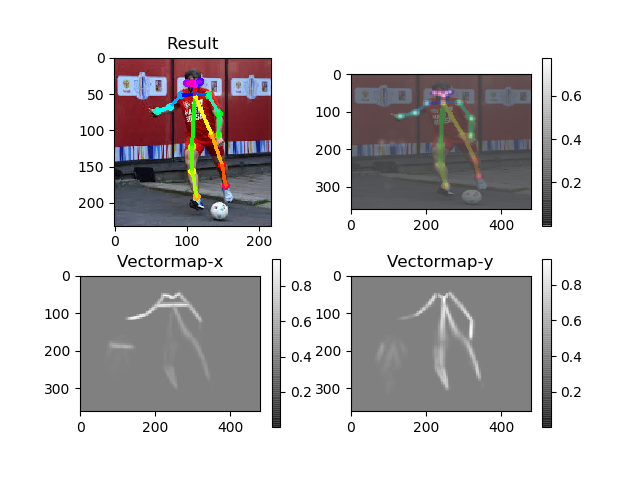

In [17]:
Image(filename='../results/test.png') 

From our testing in imgtest.ipynb, we find that calling *humans* from our code will return our keypoint information in the following form:

In [10]:
# do not run cell, this is for demonstration purposes
# humans

[BodyPart:0-(0.51, 0.17) score=0.69 BodyPart:1-(0.51, 0.21) score=0.57 BodyPart:2-(0.42, 0.22) score=0.49 BodyPart:3-(0.35, 0.29) score=0.55 BodyPart:4-(0.27, 0.32) score=0.53 BodyPart:5-(0.60, 0.21) score=0.43 BodyPart:6-(0.66, 0.33) score=0.53 BodyPart:7-(0.66, 0.46) score=0.56 BodyPart:8-(0.49, 0.53) score=0.16 BodyPart:9-(0.49, 0.67) score=0.13 BodyPart:10-(0.52, 0.82) score=0.31 BodyPart:11-(0.62, 0.46) score=0.13 BodyPart:12-(0.68, 0.63) score=0.17 BodyPart:13-(0.70, 0.76) score=0.30 BodyPart:14-(0.49, 0.15) score=0.78 BodyPart:15-(0.52, 0.14) score=0.74 BodyPart:16-(0.46, 0.14) score=0.68 BodyPart:17-(0.54, 0.14) score=0.55]

Where we are given keypoint information within a list, where each element in a list corresponds to a detected human.<br/>
The type of each element is given as: 

In [8]:
# do not run cell, this is for demonstration purposes
# type(humans[0])

tf_pose.estimator.Human

And we find that we can convert the elements to string data for our purposes.

In [9]:
# do not run cell, this is for demonstration purposes
# str(humans[0])

'BodyPart:0-(0.51, 0.17) score=0.69 BodyPart:1-(0.51, 0.21) score=0.57 BodyPart:2-(0.42, 0.22) score=0.49 BodyPart:3-(0.35, 0.29) score=0.55 BodyPart:4-(0.27, 0.32) score=0.53 BodyPart:5-(0.60, 0.21) score=0.43 BodyPart:6-(0.66, 0.33) score=0.53 BodyPart:7-(0.66, 0.46) score=0.56 BodyPart:8-(0.49, 0.53) score=0.16 BodyPart:9-(0.49, 0.67) score=0.13 BodyPart:10-(0.52, 0.82) score=0.31 BodyPart:11-(0.62, 0.46) score=0.13 BodyPart:12-(0.68, 0.63) score=0.17 BodyPart:13-(0.70, 0.76) score=0.30 BodyPart:14-(0.49, 0.15) score=0.78 BodyPart:15-(0.52, 0.14) score=0.74 BodyPart:16-(0.46, 0.14) score=0.68 BodyPart:17-(0.54, 0.14) score=0.55'

We will utilize regex to extract our required information from the string data to avoid having to alter the base code of the estimator unnecessarily.

## Keypoint Extraction<a id=extraction></a>
We extract the code we require from the run_video.py file to perform our keypoint extraction from our videos.<br/>
The code below is necessary for the keypoint estimator to run.

In [2]:
logger = logging.getLogger('TfPoseEstimator-Video')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

fps_time = 0

The code uses the argparse library to accept arguments from the command line to run the python estimator files.<br/>
For our own ease of use, we shall use the parser later on to alter the runtime arguments. 

In [3]:
parser = argparse.ArgumentParser(description='tf-pose-estimation Video')
parser.add_argument('--video', type=str, default='')
parser.add_argument('--resolution', type=str, default='432x368', help='network input resolution. default=432x368')
parser.add_argument('--model', type=str, default='mobilenet_thin', help='cmu / mobilenet_thin / mobilenet_v2_large / mobilenet_v2_small')
parser.add_argument('--show-process', type=bool, default=False,
                    help='for debug purpose, if enabled, speed for inference is dropped.')
parser.add_argument('--showBG', type=bool, default=True, help='False to show skeleton only.')

_StoreAction(option_strings=['--showBG'], dest='showBG', nargs=None, const=None, default=True, type=<class 'bool'>, choices=None, help='False to show skeleton only.', metavar=None)

We create an empty dataframe with x and y coordinates for each of our 17 bodyparts as our column headers.<br/>
We will extract keypoint information and fill our dataframe as we run our estimator on our videos.

In [4]:
lis=[]
for x in range(1,18):
    lis.append('x'+str(x))
    lis.append('y'+str(x))
data=pd.DataFrame(columns=lis)
data

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17


We create a function that will take in a string of arguments to run our estimator on a video and save a dataframe of keypoint values to csv file.<br/>
From lines 25 to 32, we utilize regex to extract keypoint information and append our frame-by-frame data onto our previously created empty dataframe.<br/>
Line 49 exports our dataframe to a csv file where the file is named automatically based on the name of the video. 

In [5]:
def video(args):
    
    fps_time = 0
    
    lis=[] # we create our empty dataframe in the function as a precaution
    for x in range(1,18):
        lis.append('x'+str(x))
        lis.append('y'+str(x))
    data=pd.DataFrame(columns=lis)
    
    logger.debug('initialization %s : %s' % (args.model, get_graph_path(args.model)))
    w, h = model_wh(args.resolution)
    e = TfPoseEstimator(get_graph_path(args.model), target_size=(w, h))
    cap = cv2.VideoCapture(args.video)
    i=0

    if cap.isOpened() is False:
        print("Error opening video stream or file")
    while cap.isOpened():
        try:
            ret_val, image = cap.read()
            humans = e.inference(image, upsample_size=4.0)
        except:
            break
        try:
            part=re.findall('BodyPart:(.*?)-',str(humans[0])) #extract bodypart numbers to list 'part'
            xco=re.findall('\((.*?),',str(humans[0])) #extract x coordinates to list 'xco'
            yco=re.findall(', (.*?)\)',str(humans[0])) #extract y coordinates to list 'yco'
            xpart=['x'+c for c in part] #create column headers for x coordinates for each body part
            ypart=['y'+c for c in part] #create column headers for y coordinates for each body part
            test1=pd.DataFrame([xco+yco],columns=xpart+ypart) #create a dataframe of keypoints for this video frame
            data=pd.concat([data,test1],sort=True) #append keypoint information to previously created dataframe
            i+=0.002
#             if len(data)>=500: #run these 3 lines of code to output a csv file for every 500 rows appended to the dataframe
#                 data.to_csv(r'.\\data\\'+re.search('n/(.*?).mp4',args.video).group(1)+'_'+str(i)+'.csv', index=False)
#                 data=data[0:0]
        except:
            continue
        if not args.showBG:
            image = np.zeros(image.shape)
        image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

        cv2.putText(image, "FPS: %f" % (1.0 / (time.time() - fps_time)), (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.imshow('tf-pose-estimation result', image)
        fps_time = time.time()
        if cv2.waitKey(1) == 27:
            break
    
    data.to_csv(r'.\\data\\'+re.search('n/(.*?).mp4',args.video).group(1)+'_'+str(i)+'.csv', index=False) #output csv to 'data' folder, with csv name based on arguments specified
    cv2.destroyAllWindows()
    logger.debug('finished+')
    return(data)

We then run this function for our 6 cleaned videos to obtain 6 csv files which we use for modelling.

In [ ]:
args=parser.parse_args(("--video=../train/control.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../train/Guardclean.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../train/Jabclean.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../train/Crossclean.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../train/Hookclean.mp4 --model=cmu").split())
video(args)

In [ ]:
args=parser.parse_args(("--video=../train/Uppercutclean.mp4 --model=cmu").split())
video(args)